<a href="https://colab.research.google.com/github/mugobrian201/portfolio/blob/main/Apartment_Prices_in_Argentina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


PROJECT : Predicting Apartment Prices in Buenos Aires: A Data Science Approach Using Size and Location

This project demonstrates a complete data science workflow to build a predictive model for apartment prices in Buenos Aires, Argentina. The primary goal was to identify and quantify the key factors that influence real estate valuations, providing a data-driven tool for estimation.

The analysis began with a targeted data cleaning and preprocessing phase. Using a custom wrangle function, the dataset—sourced from Kaggle—was refined by filtering for apartments specifically within the 'Distrito Federal' (Buenos Aires) and removing outliers to ensure data quality. A crucial feature, price_per_m2, was engineered by calculating the price in USD relative to the covered surface area, setting the stage for a clear analysis of value.

The modeling process adopted an iterative approach to isolate the impact of different features. The initial model used only apartment size (surface_covered_in_m2) to predict the total price. This simple Linear Regression model successfully beat a baseline prediction, establishing a strong, positive relationship where larger apartments command higher prices—approximately $2,045 more for each additional square meter.

To enhance the model's accuracy, a second model was developed using geographical coordinates (lat and lon) as features. While this location-based model also outperformed the baseline, its performance was inferior to the size-based model, indicating that, for this dataset, square footage is a more potent individual predictor.

The most effective model emerged from combining both features—size and location—into a single predictor. This multifaceted model leveraged a pipeline to handle the data and perform the regression, resulting in the best performance of the three. This key finding underscores that while size is a dominant factor, incorporating location provides a more nuanced and accurate price estimation, reflecting the complex nature of real estate valuation.

This project has direct practical applications. For prospective buyers or renters, it offers a transparent method to gauge if an asking price is reasonable. For investors and real estate professionals, it highlights the primary value drivers in the Buenos Aires market, enabling better investment decisions and market analysis. The model serves as a foundational tool that could be expanded with more features (e.g., number of bedrooms, building amenities) for even greater accuracy.

This project is a good example of the data science lifecycle, showcasing skills in data wrangling, feature engineering, iterative model building, and validation. It effectively illustrates how to start with a simple model, interpret its results (coefficients and intercepts), and systematically improve it by incorporating additional variables, a critical process for solving real-world problems.




Objective

    1.To Build a Predictive Model for Apartment Prices

    The primary goal was to develop a machine learning model capable of accurately estimating the price of an apartment in Buenos Aires based on its fundamental characteristics.

    2.To Identify and Quantify Key Price Drivers

    To determine which factors have the most significant impact on apartment prices. Specifically, the project sought to answer:

     How strong is the relationship between apartment size (square meters) and price?

     Can geographic location (latitude/longitude) within the city effectively predict price?

     Does a combination of size and location provide a superior prediction?

    3.To Demonstrate a Complete Data Science Workflow

    To showcase proficiency in the end-to-end process of a data science project, from data acquisition and cleaning to model deployment and interpretation. This includes:

     Data Wrangling: Cleaning raw data and creating a robust dataset for analysis.

     Feature Engineering: Creating new, meaningful features like price_per_m2.

     Iterative Modeling: Building and comparing multiple models to incrementally improve performance.

     Model Interpretation: Extracting and explaining the model's coefficients to make the predictions understandable (e.g., quantifying the price increase per additional square meter).

    4.To Provide Actionable, Data-Driven Insights

    To translate the model's findings into clear, actionable insights about the Buenos Aires real estate market.

    5.To Establish a Foundation for Further Analysis

    To create an analytical framework that can be easily expanded in the future by incorporating additional features (like number of bedrooms, proximity to amenities, etc.) for even more sophisticated price modeling.



IMPORTING THE NECESSARY MODELS

In [ ]:
# Install the kagglehub library
!pip install kagglehub

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# This makes your plots show up directly in the notebook
%matplotlib inline

UPLOADING MY FILE

In [ ]:
from google.colab import files
files.upload()

CREATING A WRANGLE FUNCTION

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath)
  #Drop irrelevant columns
  df.drop(columns=["price", "price_aprox_local_currency", "surface_total_in_m2", "price_per_m2"], inplace=True)
  #Create a new column "price_per_m2"
  df["price_per_m2"] = df["price_aprox_usd"] / df["surface_covered_in_m2"]
  #Creating a Mask that shows states only in 'Distrito Federal'
  mask_state = df["State"].str.contains("Distrito Federal")
  #Creating a mask where the property type is apartments only
  mask_apt = df["property_type"] == "apartment"
  #Create a mask where 'price_aprox_usd' < 400_000
  mask_price = df["price_aprox_usd"] < 700_000
  #Removing Outliers from "surface_covered_in_m2" column
  low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
  mask_area = df["surface_covered_in_m2"].between(low, high)


  df = df[mask_state & mask_apt & mask_price & mask_area]

  #Reset the index after filtering (cleaner indexing)
  df.reset_index(drop=True, inplace=True)

  return df

PREPARE DATA

IMPORT

In [ ]:
df = wrangle("cleaned_property_data.csv")
print(df.shape)
df.head()

(289, 9)


,operation,property_type,price_aprox_usd,surface_covered_in_m2,properati_url,lat,lon,State,price_per_m2
0,sell,apartment,172446.86,83.0,http://benito-juarez.properati.com.mx/qc0v_ven...,19.379406,-99.159145,Distrito Federal,2077.673012
1,sell,apartment,553339.27,320.0,http://cuajimalpa-de-morelos.properati.com.mx/...,19.390415,-99.254997,Distrito Federal,1729.185219
2,sell,apartment,492618.62,159.0,http://benito-juarez.properati.com.mx/duj8_ven...,19.375395,-99.165759,Distrito Federal,3098.230314
3,sell,apartment,155425.12,73.0,http://benito-juarez.properati.com.mx/or2f_ven...,19.394073,-99.153915,Distrito Federal,2129.111233
4,sell,apartment,258224.99,84.0,http://cuauhtemoc.properati.com.mx/j9by_venta_...,19.416967,-99.165850,Distrito Federal,3074.107024


EXPLORE

VISUALIZATION OF "SURFACE_COVERED_IN_M2 COLUMN"

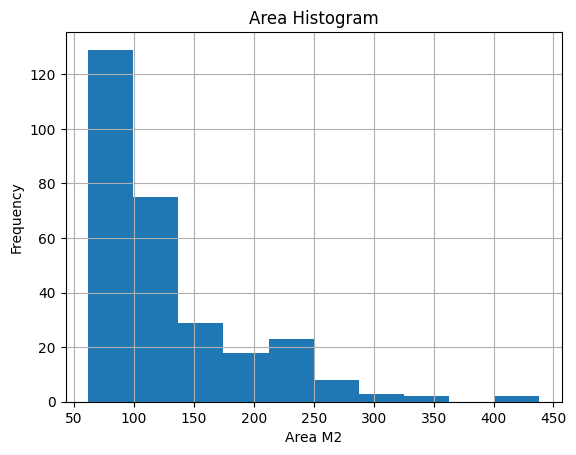

In [ ]:
#Area Histogram
df["surface_covered_in_m2"].hist()
plt.xlabel("Area M2")
plt.ylabel("Frequency")
plt.title("Area Histogram");

In [ ]:
df["surface_covered_in_m2"].describe()

,surface_covered_in_m2
count,289.000000
mean,125.698962
std,65.831983
min,62.000000
25%,78.000000
50%,101.000000
75%,156.000000
max,438.000000


The Histogram is highly skewed to the right, thus suggesting there are outliers in the dataset which might affect model perfomance. Also with the area statistics where the mean(112.5333), and the max being 1118 proves there are outliers. I will remove those outliers making sure all observations fall between 0.1 and 0.9 Quantiles

 VISUALIZATION TO CHECK THE RELATIONSHIP BETWEEN APARTMENT PRICE AND SIZE

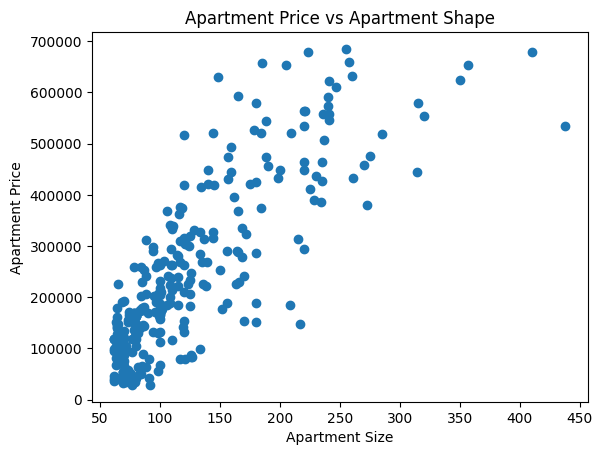

In [ ]:
#Plot a Scatter Plot
plt.scatter(x=df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.xlabel("Apartment Size")
plt.ylabel("Apartment Price")
plt.title("Apartment Price vs Apartment Shape");

From the above visualization, we can see that there is a positive correlation between apartment price and size, meaning that if we want to price an apartment, it would be good to include its size

It shows that area does determine the price of an apartment.

Split Data : Feature Matrix

Training my model with only one feature, "surface_covered_in_m2"

In [ ]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(289, 1)

Split Data: Target Vector

Creating a Target Vector to train my model

In [ ]:
target = "price_aprox_usd"               #no listing it since it is a vector
y_train = df[target]
y_train.shape

(289,)

I want to build a Model that will predict a continuous numerical value, that is, the price of an apartment.
I want to fit a model that will predict a single output variable(y) as a linear function of a single input variable(X).
This is a regression problem, a LinearRegression model will be the best.


BUILD MODEL

Baseline

In [ ]:
y_mean = y_train.mean()
y_mean

np.float64(248004.589550173)

The above output shows the prediction that our dumb/naive model will make

Prediction List
Generating a list that repeats the prediction for every observation in my dataset.
It will contain the value of y_mean repeated so that it is the same length at y_train

In [ ]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline

Baseline : Scatter Plot & Line Plot

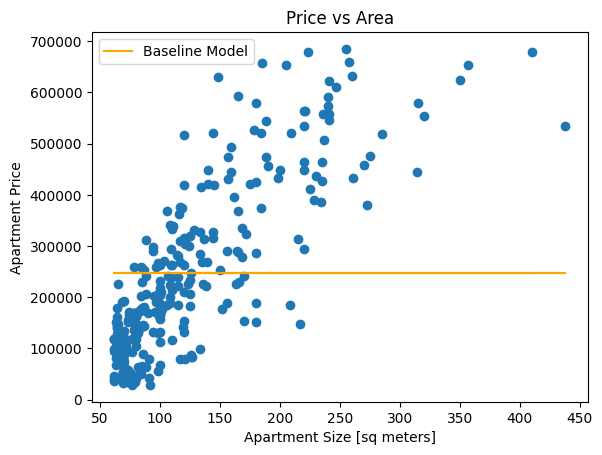

In [ ]:
plt.plot (X_train["surface_covered_in_m2"], y_pred_baseline, color="orange", label = "Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Apartment Size [sq meters]")
plt.ylabel("Apartment Price")
plt.title("Price vs Area")
plt.legend();

This visualization shows the preciction of Apartment Prices our dumb/naive model will always make

Baseline : Mean Absolute Error (MAE)

Calculating y_pred_baseline mae to understand it better

In [ ]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt prices:", round(y_mean,2))
print("Baseline mae:", round(mae_baseline, 2))

Mean apt prices: 248004.59
Baseline mae: 134526.4


The Output means that if we always predict that an apartment price is 248004.19 USD, our predictions would be off by an average of 113478.59 USD

For my model to work, then the difference needs to be below 113478.59 USD for it to be useful

ITERATE

Instantiate Model

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

EVALUATE

I am trying to see how well my model performs when making predictions for the data it saw during training

That is, generating predictions using a trained model

In [ ]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([160670.83468735, 645415.63791418, 316116.42559554, 140217.46746259,
       162716.17140983])

Training MAE

In [ ]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 71955.77


My model has beat the Baseline by 41522.82 USD. This is a good indicator that the model will be helfpul in predicting Apartment Prices.

Communicating Results

Extracting the Model Intercept and Coefficient and generating an equation



y = β₀ + β₁x     

where y = apartment_price, β₀ = intercept(where the line crosses the y_intercept), β₁ = coefficient, x = surface_covered_in_m2

In [ ]:
#Extract Model Intercept
intercept = (model.intercept_).round(2)
print("Model Intercept:", intercept)
#Extract Coefficient
coefficient = (model.coef_[0]).round(2)
print("Model for 'surface_covered_in_m2':", coefficient)
#Generating an equation
print(f"apt_price = {intercept} + {coefficient} * surface_covered_in_m2")

Model Intercept: -9092.11
Model for 'surface_covered_in_m2': 2045.34
apt_price = -9092.11 + 2045.34 * surface_covered_in_m2


Intercept (β₀ = -9092.11)

Means the predicted price when surface_covered_in_m2 = 0

Coefficient (β₁ = 2045.34)

Means for every 1 square meter increase in size, the apartment price increases by 2045.34 USD


Example Prediction: 150 m² Apartment


apt_price = -9092.11 + 2045.34 * 150

apt_price = -9092.11 + 306801

apt_price = 297,708.89 USD

The linear regression model estimates that apartment prices in Distrito Federal increase by approximately 2045 USD for each additional square meter of space. For a typical 150 m² apartment, the model predicts a price of around 298000 USD.

VISUALIZATION : LINE AND SCATTER PLOT

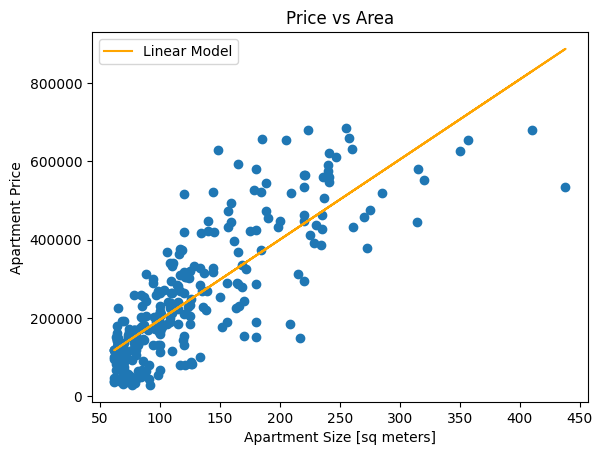

In [ ]:
plt.plot(X_train, y_pred_training, color = "Orange", label = "Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("Apartment Size [sq meters]")
plt.ylabel("Apartment Price")
plt.title("Price vs Area")
plt.legend();

The linear regression model reveals a clear positive relationship between apartment size and price in Buenos Aires in the state 'Distrito Federal'. As expected, larger apartments command higher prices with the model estimating a price increase of approximately 2045.34 USD for each additional square meter.


Visually, we can observe that most data points cluster in the 50-150 m² range, with prices typically between $100,000-$300,000. The linear trend line fits this central cloud of points reasonably well, suggesting that size alone explains a significant portion of price variation for typical apartments

Model Limitations;
There's considerable vertical spread around the trend line, indicating that factors beyond just size.

The model appears less reliable for very large apartments (>200 m²), where price variability increases significantly.
This confirms that while apartment size is a fundamental pricing factor, it alone is insufficient for accurate price prediction across all market segments

PREDICTING PRICE WITH LOCATION

In [ ]:
#Scatter Plot of "lat" and "lon" columns
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    width = 600,
    height = 600,
    color = "price_aprox_usd",
    hover_data = ["price_aprox_usd"]
)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

In [ ]:
#3D Scatter plot
fig = px.scatter_3d(
    df,
    x = "lon",
    y = "lat",
    z = "price_aprox_usd",
    labels = {"lon": "longitude", "lat":"latitude", "price_aprox_usd":"price"},
    width = 600,
    height = 600
)
#Refine Formatting
fig.update_traces(
    marker = {"size":4, "line":{"width":2, "color":"DarkSlateGrey"}},
    selector = {"mode":"markers"}
)
fig.show()

Split : Feature Matrices & Target Vector

In [ ]:
features_location = ["lat", "lon"]
X_train_location = df[features_location]
print("X_train_location:", X_train_location.shape)
target_location = "price_aprox_usd"
y_train_location = df[target_location]
print("X_train_location:", y_train_location.shape)

X_train_location: (289, 2)
X_train_location: (289,)


BUILD MODEL

Baseline

In [ ]:
y_mean_location = y_train_location.mean()
print(round(y_mean_location,2))

248004.59


In [ ]:
y_pred_baseline_location = [y_mean_location] * len(y_train_location)
print(y_pred_baseline_location[:5])

[np.float64(248004.589550173), np.float64(248004.589550173), np.float64(248004.589550173), np.float64(248004.589550173), np.float64(248004.589550173)]


In [ ]:
mae_baseline_location = mean_absolute_error(y_train_location, y_pred_baseline_location)
print("Mean apt price:",round(y_mean_location, 2))
print("MAE Baseline:", round(mae_baseline_location, 2))

Mean apt price: 248004.59
MAE Baseline: 134526.4


ITERATE

Instantiating and Transforming my Model

In [ ]:
model_location = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)
model_location.fit(X_train_location, y_train_location)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

EVALUATE

In [ ]:
#Generate predictions
y_pred_training_location = model_location.predict(X_train_location)
y_pred_training_location[:5]

array([219989.98813236, 355752.58363336, 226643.64638615, 221269.93206397,
       250420.44194412])

MAE Training

In [ ]:
mae_training_location = mean_absolute_error(y_train_location, y_pred_training_location)
mae_training_location

115762.61314717871

The location model is performing better than the baseline, which is exactly what should happen. The improvement (from 134k to 115k MAE)

This confirms that apartments in different areas have systematically different prices

Also confirms that "lat" and "lon" columns are not strong predictors as size is.

COMMUNICATING RESULTS

In [ ]:
#Extract Intercept and Coefficients and generating an equation
intercept_location = model_location.named_steps["linearregression"].intercept_
print("intercept:", round(intercept_location,2))
coefficient_location = model_location.named_steps["linearregression"].coef_
print("coefficient:", coefficient_location)
print(f"price_of_apt = {intercept} + ({coefficient}*longitude) + ({coefficient}*latitude)")

intercept: -144772603.0
coefficient: [  568977.28626653 -1351021.65056644]
price_of_apt = -9092.11 + (2045.34*longitude) + (2045.34*latitude)


As you move North and East, the predicted apartment size increases

In [ ]:
#3D Scatter plot
fig = px.scatter_3d(
    df,
    x = "lat",
    y = "lon",
    z = "price_aprox_usd",
    labels = {"lat": "latitude", "lon":"longitude", "price_aprox_usd":"price"},
    width = 600,
    height = 600
)
#Refine Formatting
fig.update_traces(
    marker = {"size":4, "line":{"width":2, "color":"DarkSlateGrey"}},
    selector = {"mode":"markers"}
)
fig.show()
#Create x and y coordinates for model presentation
x_plane = np.linspace(df["lat"].min(), df["lat"].max(),10)
y_plane = np.linspace(df["lon"].min(), df["lon"].max(),10)
xx, yy = np.meshgrid(x_plane, y_plane)
#Use Model to predict z-coordinates
z_plane = model_location.predict(pd.DataFrame({"lat": x_plane, "lon": y_plane}))
zz = np.tile(z_plane, (10,1))

In [ ]:
# 3D Scatter plot
fig = px.scatter_3d(
    df,
    x="lat",
    y="lon",
    z="price_aprox_usd",
    labels={"lat": "latitude", "lon":"longitude", "price_aprox_usd":"price"},
    width=600,
    height=600
)

# Refine Formatting
fig.update_traces(
    marker={"size":4, "line":{"width":2, "color":"DarkSlateGrey"}},
    selector={"mode":"markers"}
)

# Create x and y coordinates for model presentation
x_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
y_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use Model to predict z-coordinates
# First, create a proper DataFrame with all combinations
xy_combined = np.column_stack([xx.ravel(), yy.ravel()])
z_plane = model_location.predict(pd.DataFrame(xy_combined, columns=["lat", "lon"]))
zz = z_plane.reshape(xx.shape)  # Reshape to match the grid

# Add the plane to the plot
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5, colorscale='Blues'))

fig.show()

PREDICTING PRICE WITH BOTH SIZE AND LOCATION

Split Data : Feature Matrices & Target Vector

In [ ]:
features_all = ["surface_covered_in_m2", "lat", "lon"]
X_train_all = df[features_all]
print(X_train_all.shape)
target_all = "price_aprox_usd"
y_train_all = df[target_all]
print(y_train_all.shape)

(289, 3)
(289,)


BUILD MODEL

Baseline

In [ ]:
y_mean_all = y_train_all.mean()
y_mean_all

np.float64(248004.589550173)

In [ ]:
y_pred_baseline_all = [y_mean_all] * len(y_train_all)
y_pred_baseline_all[:5]

[np.float64(248004.589550173),
 np.float64(248004.589550173),
 np.float64(248004.589550173),
 np.float64(248004.589550173),
 np.float64(248004.589550173)]

Baseline : Mean Absolute Error (MAE)

In [ ]:
mae_baseline_all = mean_absolute_error(y_train_all, y_pred_baseline_all)
mae_baseline_all

134526.40215418878

Iterate

Model Transformation and Instantiation

In [ ]:
model_all = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)
model_all.fit(X_train_all, y_train_all)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

Evaluate

In [ ]:
y_pred_training_all = model_all.predict(X_train_all)
y_pred_training_all[:5]

array([154846.04697037, 662169.09378526, 299629.57147433, 136451.25636277,
       170583.86220609])

MAE Training

In [ ]:
mae_training_all = mean_absolute_error(y_train_all, y_pred_training_all)
mae_training_all

67936.67888485112

The Model with both Size and Location has beat the baseline and has performed better than the previous models where I tried to predict price with the individual features. It will be more helpful in predicting Price that the previous LinearRegression Models.

Communicate Results

Extract Coefficients and Intercept and generating an Equation

In [ ]:
intercept_all = model_all.named_steps["linearregression"].intercept_
print("intercept:", intercept_all)
coefficient_all = model_all.named_steps["linearregression"].coef_
print("coefficient:", coefficient_all)
#Generating an equation
print(f"apt_price = {intercept_all} + {coefficient_all}*surface_covered_in_m2 + {coefficient_all}*latitude + {coefficient_all}*longitude")

intercept: -70670987.96210913
coefficient: [   1860.5358418   250984.76330801 -663655.11922083]
apt_price = -70670987.96210913 + [   1860.5358418   250984.76330801 -663655.11922083]*surface_covered_in_m2 + [   1860.5358418   250984.76330801 -663655.11922083]*latitude + [   1860.5358418   250984.76330801 -663655.11922083]*longitude
